In [69]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys 
import configparser
import pandas as pd 
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from os.path import join as oj
import pickle as pkl
sys.path.insert(0, "../src")
from utils.dice_score import multiclass_dice_coeff,dice_loss
from torch.utils.data import DataLoader, TensorDataset
import my_data
from unet import UNet
import pickle as pkl
pd.set_option('display.float_format', lambda x: '%.3f' % x)
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
config = configparser.ConfigParser()
config.read('../config.ini');
data_path =config['DATASET']['data_path'] 
from torch.nn import functional as F

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
fnames = sorted([oj(config['PATHS']['model_path'] , fname) for fname in os.listdir(config['PATHS']['model_path'] ) if "pkl" in fname]) 
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 

results = pd.concat(results_list, axis=1).T.infer_objects()

results.experiment_name.unique()
results['best_val_score'] = [max(x) for x in results.val_scores]
results[['foldername',  
         'final_dice_score','cost_function', 'add_ratio', 'test_dice_score',
         'experiment_name']].groupby([ 'experiment_name', 'cost_function','foldername','add_ratio', ]).mean()

final_dice_score  \
experiment_name cost_function foldername   add_ratio                     
TryNoDice       cut_off_cost  lno_halfHour 0.010                 0.941   
                random_cost   lno_halfHour 0.010                 0.931   

                                                      test_dice_score  
experiment_name cost_function foldername   add_ratio                   
TryNoDice       cut_off_cost  lno_halfHour 0.010                0.999  
                random_cost   lno_halfHour 0.010                1.000

In [95]:
results = results[results.experiment_name == 'TryNoDice']
# results = results[results.add_ratio	 == .01]
results = results.reset_index()

In [96]:
x,y,num_classes,class_dict = my_data.load_layer_data(oj(data_path, 'lno_halfHour'))
x,y,num_classes_2,class_dict2 = my_data.load_layer_data(oj(data_path, 'lno'))
x_test, y_test = x[-4:], y[-4:]
x, y = x[:-4], y[:-4]  # just don't touch the last four
print(x.max())
x = x/x.max()
x_test = x_test/x_test.max()

image_size = 128
offset = 64

255.0


In [97]:
for j in tqdm(range(len(results))):
    net = UNet(1, results.num_classes[0], )
    net.load_state_dict(torch.load(oj(config['PATHS']['model_path'] ,results.file_name[j]+".pt")))
    net = net.to(device).eval()
    y_pred = []
    for i in range(len(x_test)):
        y_pred_nu = net(torch.Tensor(x_test[i]).unsqueeze(0).to(device)).cpu().detach().numpy()
        y_pred.append(y_pred_nu)
    y_pred = np.asarray(y_pred).squeeze().argmax(axis=1)
    y_pred_one_hot = torch.nn.functional.one_hot(torch.Tensor(y_pred).to(torch.int64), 
                                                num_classes=3).permute(0, 3, 1, 2)
    results.at[j, 'test_dice_score'] = multiclass_dice_coeff(y_pred_one_hot.float(), 
                        torch.Tensor(y_test), 
                        num_classes=3).item()
    

  0%|          | 0/2 [00:00<?, ?it/s]

In [101]:
'ddDDD'.lower()


'ddddd'

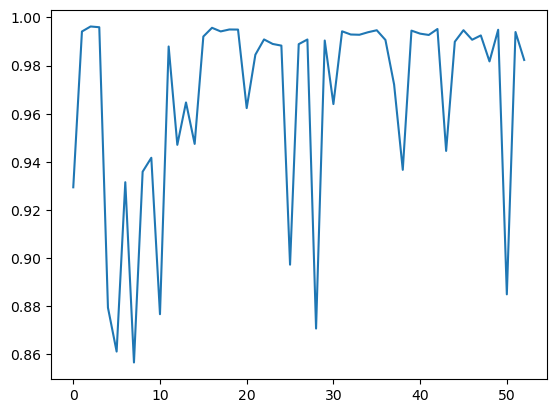

In [100]:
plt.plot(results.val_scores[0])

In [99]:
results[['foldername',  
         'test_dice_score','cost_function', 'add_ratio',
         'experiment_name']].groupby([ 'experiment_name', 'cost_function','foldername','add_ratio', ]).mean()

test_dice_score
experiment_name cost_function foldername   add_ratio                 
TryNoDice       cut_off_cost  lno_halfHour 0.010                0.970
                random_cost   lno_halfHour 0.010                0.965

In [17]:
net.load_state_dict(torch.load(oj(config['PATHS']['model_path'] ,results.file_name[6]+".pt")))
net = net.to(device).eval()

In [54]:
img_idx = 3
test_img_np  = ((x_test[img_idx][None, ].astype(np.float32) ))
with torch.no_grad():
    img_t = torch.Tensor(test_img_np).to(device)
    output = net.forward(img_t).cpu().detach().numpy()[0]

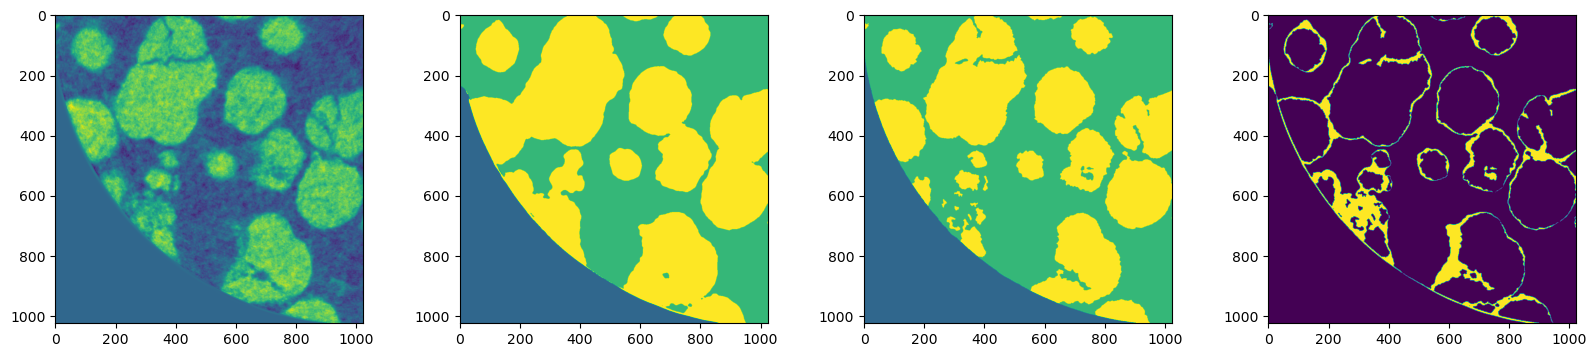

In [55]:
fig, axes = plt.subplots(ncols = 4, figsize = (20,4))
axes[0].imshow(x_test[img_idx][0])
axes[1].imshow(np.argmax(output, axis=0),vmin =-1, vmax = 2)
target = np.copy(y_test[img_idx]).astype(np.int16)
target[np.where(target == 255)] =-1
axes[2].imshow(target, vmin =-1,vmax = 2)
axes[3].imshow((target !=np.argmax(output, axis=0) ) * (target !=-1))
# axes[1].imshow()

# try with detailed

In [ ]:
x,y,num_classes,_ = my_data.load_layer_data(oj(data_path, 'lno'))

x, y = x[:-4], y[:-4]  # just don't touch the last four
x = x/x.max()
val_percent = .25
init_train_ratio =1
image_size = 128
offset = 64
all_idxs = np.arange(len(x))
np.random.seed(0)
np.random.shuffle(all_idxs)
n_val = np.maximum(int(len(x) * val_percent), 1)
n_train = len(x) - n_val
all_train_idxs = all_idxs[:n_train]
val_idxs = all_idxs[n_train:]
init_train_idxs = all_train_idxs[: np.maximum(1, int(init_train_ratio * n_train))]
pool_idxs = all_train_idxs[np.maximum(1, int(init_train_ratio * n_train)) :]

val_set = TensorDataset(
    *[
        torch.Tensor(input)
        for input in my_data.make_dataset(
            x[val_idxs[:1]],
            y[val_idxs[:1]],
            img_size=image_size,
            offset=image_size,
        )
    ]
)
val_loader = DataLoader(val_set, shuffle=False, drop_last=False, batch_size = 16)

In [ ]:
val_loader.batch_size

In [ ]:
x_small, _,=my_data.make_dataset(
            x[val_idxs[:1]],
            y[val_idxs[:1]],
            img_size=image_size,
            offset=image_size,
        )

In [ ]:
x_small[test_idxes].min()

In [ ]:
net(t)

In [ ]:
x.shape

In [ ]:
val_loader

In [ ]:
net

In [ ]:
len(all_train_idxs)

In [ ]:
len(val_loader.dataset)

In [ ]:
plt.imshow(x[val_idxs[0]][0])

In [ ]:
test_ids_safe = std_cost_function(net, device,val_loader,n_choose =59)

# test_ids = np.argsort(test_ids_safe)

In [ ]:
len(val_loader.dataset)

In [ ]:
test_ids_safe

In [ ]:
plt.imshow(val_set[test_ids_safe[0]][0][0])

In [ ]:
plt.imshow(val_set[test_ids_safe[-20]][0][0])

In [ ]:
test_ids_safe[32]

In [ ]:
test_ids_safe[23]

In [ ]:
test_ids_safe

In [ ]:
test_ids_safe

In [ ]:
test_ids_safe

In [ ]:
test_ids_safe

In [ ]:
test_ids_safe

In [ ]:
net(val_set[test_ids_safe[1]][0][None,:].to(device))[0].std(dim=1).mean(dim=(0,1))

In [ ]:
net(val_set[test_ids_safe[-1]][0][None,:].to(device))[0].std(dim=1).mean(dim=(0,1))

In [ ]:
net(val_set[test_ids_safe[-1]][0][None,:].to(device))[0][0].mean()

In [ ]:
net(val_set[test_ids_safe[-1]][0][None,:].to(device))[0][2].mean()

In [ ]:
net(val_set[test_ids_safe[-1]][0][None,:].to(device))[0].std(dim=1)

In [ ]:
test_ids_safe[224]

In [ ]:
len(test_ids_safe)

In [ ]:
test_ids = np.sort(test_ids)

In [ ]:
plt.imshow(val_set[5][0][0])

In [ ]:
plt.imshow(val_set[test_ids[10]][0][0])

In [ ]:
plt.imshow(val_set[test_ids[1]][0][0])

In [ ]:
plt.imshow(val_set[test_ids[0]][0][0])

In [ ]:
img_idx = 0
test_img_np  = ((x[img_idx][None, ].astype(np.float32) ))
with torch.no_grad():
    img_t = torch.Tensor(test_img_np).to(device)
    output = F.softmax(net.forward(img_t)[0], dim =0).cpu().detach().numpy()


In [ ]:
fig, axes = plt.subplots(ncols = 5, figsize = (20,4))
axes[0].imshow(x[img_idx][0])
axes[1].imshow(np.argmax(output, axis=0),vmin =-1, vmax = 2)
target = np.copy(y[img_idx]).astype(np.int16)
target[np.where(target == 255)] =-1
axes[2].imshow(target, vmin =-1,vmax = 2)
axes[3].imshow((target !=np.argmax(output, axis=0) ))
max_val =np.quantile(output.std(axis=0).max() - output.std(axis=0),.90)
axes[4].imshow(output.std(axis=0).max() - output.std(axis=0),vmax = max_val)
# axes[1].imshow()

In [ ]:
output.std(axis=0).max() - output.std(axis=0)

In [ ]:
with torch.no_grad():
    img_t = torch.Tensor(x[val_idxs]).to(device)
    output = F.softmax(net.forward(img_t), dim =1)


In [ ]:
(torch.argmax(output, dim = 1).detach().cpu().numpy() ==y[val_idxs]).mean()

In [ ]:
(torch.argmax(output, dim = 1).detach().cpu().numpy() ==y[val_idxs])[np.where((my_std < np.quantile(my_std, .1)))].mean()

In [ ]:
(torch.argmax(output, dim = 1).detach().cpu().numpy() ==y[val_idxs])[np.where((my_std > np.quantile(my_std, .1)))].mean()

In [ ]:
len(val_loader)

In [ ]:
val_loader

In [ ]:
eva

In [ ]:
my_std = torch.std(output,dim =1).detach().cpu().numpy()

In [ ]:
torch.argmax(output, dim = 1)

In [ ]:
np.where((my_std < np.quantile(my_std, .1)))

In [ ]:
(torch.argmax(output, dim = 1).detach().cpu().numpy() ==y[val_idxs]).mean()

In [ ]:
output.shape

In [ ]:
1-dice_loss(output, torch.Tensor(y[val_idxs]).to(device), num_classes, multiclass=True)

In [ ]:
from dice_score import dice_loss

In [ ]:
dice_loss()

In [ ]:
num_classes

In [ ]:
np.quantile(output.std(axis=0).max() - output.std(axis=0), .9)

In [ ]:
output.std(axis=0).max()

In [ ]:
(target ==np.argmax(output, axis=0) ).mean()

In [ ]:
output.std(axis=0)

# old stuff

In [ ]:
for i in range(4):
    img_idx = i
    test_img_np  = ((x[img_idx][None, ].astype(np.float32) ))
    with torch.no_grad():
        img_t = torch.Tensor(test_img_np).to(device)
        output = net.forward(img_t).cpu().detach().numpy()[0]
        show_img = np.zeros_like(y[img_idx])
        show_img[np.where(y[img_idx] ==my_data.phase_1)] =1
        show_img[np.where(y[img_idx] ==my_data.phase_2)] =2
        print((show_img ==np.argmax(output, axis=0)).mean())


In [ ]:
img_idx = -1
test_img_np  = ((x[img_idx][None, ].astype(np.float32) -my_data.mean)/my_data.std)
with torch.no_grad():
    img_t = torch.Tensor(test_img_np).to(device)
    output = net.forward(img_t).cpu().detach().numpy()[0]


In [ ]:
show_img = np.zeros_like(y[img_idx])
show_img[np.where(y[img_idx] ==my_data.phase_1)] =1
show_img[np.where(y[img_idx] ==my_data.phase_2)] =2

In [ ]:
std_large = output.std(axis=0)<np.quantile(output.std(axis=0), .1)

fig, axes = plt.subplots(ncols = 5, figsize = (20,7))
axes[0].imshow(x[img_idx,2])
axes[1].imshow(np.argmax(output, axis=0))
axes[2].imshow(show_img)
axes[3].imshow(show_img !=np.argmax(output, axis=0) )

axes[4].imshow(std_large)

In [ ]:
x.shape

In [ ]:
std_large = output.std(axis=0)<np.quantile(output.std(axis=0), .05)

fig, axes = plt.subplots(ncols = 3, figsize = (20,8))
# axes[0].imshow(x[img_idx,2])
axes[0].imshow(np.argmax(output, axis=0))
# axes[2].imshow(show_img)
axes[1].imshow(show_img !=np.argmax(output, axis=0) )

axes[2].imshow(std_large)

In [ ]:
(show_img !=np.argmax(output, axis=0))[np.where(1-std_large)].mean()

In [ ]:
(show_img ==np.argmax(output, axis=0)).mean()

In [ ]:
correct = np.reshape(show_img !=np.argmax(output, axis=0),-1)
std = np.reshape(output.std(axis=0), -1)

In [ ]:
std_large = output.std(axis=0)<np.quantile(output.std(axis=0), .1)

fig, axes = plt.subplots(ncols = 5, figsize = (20,7))
axes[0].imshow(x[img_idx,2])
axes[1].imshow(np.argmax(output, axis=0))
axes[2].imshow(show_img)
axes[3].imshow(show_img !=np.argmax(output, axis=0) )

axes[4].imshow(std_large)

In [ ]:
std_large = output.std(axis=0)<np.quantile(output.std(axis=0), .1)

fig, axes = plt.subplots(ncols = 1, figsize = (20,7))
axes.imshow(x[img_idx,2][200:400,350:600])

# axes[4].imshow(std_large)

In [ ]:
x.shape

In [ ]:
plt.imshow(x[0,2])

In [ ]:
plt.imshow(x[-1,2])

In [ ]:
x[img_idx,2][200:400,350:600]